# Killbills : Clusterisation de données de tickets de caisse

<font size=”14”>Dans un premier temps, j'ai importé les bibliothèques nécessaires à mon projet. J'ai utilisé pandas et numpy pour le traitement des données, SentenceTransformer pour la conversion du texte en représentations numériques, StandardScaler pour la mise à l'échelle des données, KMeans et AgglomerativeClustering pour le clustering, et d'autres pour la visualisation et le traitement du texte.</font>

In [34]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import re
import random
import warnings
warnings.filterwarnings("ignore")

Ensuite, j'ai importé mes données à partir du fichier CSV. J'ai supprimé certaines colonnes qui n'étaient pas pertinentes pour ma tâche de clustering et j'ai éliminé les lignes où certaines données étaient manquantes dans les colonnes 'amount', 'taxRate', 'itemName' et 'description'. J'ai créé une nouvelle colonne 'itemdescription' en combinant 'itemName' et 'description', et j'ai supprimé tous les chiffres de cette nouvelle colonne.

In [3]:
df = pd.read_csv('killbillsdata.csv', parse_dates=['date', 'createdAt', 'updatedAt'])

columns_to_drop = ['Unnamed: 0', 'parent', 'taxDescription', 'storeId', 'createdAt', 'updatedAt']
df = df.drop(columns=columns_to_drop)

df.dropna(subset=['amount', 'taxRate', 'itemName','description'], inplace=True)

/tmp/ipykernel_156418/3398339711.py:1: DtypeWarning: Columns (0,2,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('killbillsdata.csv', parse_dates=['date', 'createdAt', 'updatedAt'])


In [4]:
df['itemdescription'] = df['itemName'] + ' ' + df['description']
df['itemdescription'] = df['itemdescription'].apply(lambda x: re.sub(r'\d+', '', x))

Dans le but de préparer mes données pour le clustering, j'ai normalisé les colonnes 'amount' et 'taxRate' en utilisant la méthode StandardScaler de sklearn. J'ai également extrait un échantillon de 20000 lignes de mes données pour des raisons de performance.

In [5]:
scaler = StandardScaler()
df['amount_scaled'] = scaler.fit_transform(df[['amount']])
df['taxRate_scaled'] = scaler.fit_transform(df[['taxRate']])

In [6]:
sample_df = df.sample(n=20000, random_state=42)

Pour la phase d'encodage, j'ai converti les descriptions textuelles des articles en vecteurs numériques à l'aide de la bibliothèque SentenceTransformer. J'ai ensuite combiné ces vecteurs encodés avec les valeurs normalisées de 'taxRate' et 'amount' pour former un ensemble de caractéristiques qui a été utilisé pour le clustering.

In [7]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
itemdescription_embeddings = model.encode(sample_df['itemdescription'].tolist(), convert_to_tensor=True)

In [8]:
features = np.concatenate((itemdescription_embeddings, sample_df[['taxRate_scaled', 'amount_scaled']].values), axis=1)

Après la préparation des données, j'ai déterminé le nombre de clusters pour l'algorithme K-means en utilisant la méthode du coude. J'ai entrainé plusieurs modèles K-means avec un nombre de clusters allant de 2 à 10 et j'ai tracé leur inertie. J'ai réalisé le clustering en utilisant K-means avec 4 clusters et le clustering agglomératif avec 8 clusters.

/home/mano/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mano/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mano/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mano/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mano/anaconda3/lib/pyt

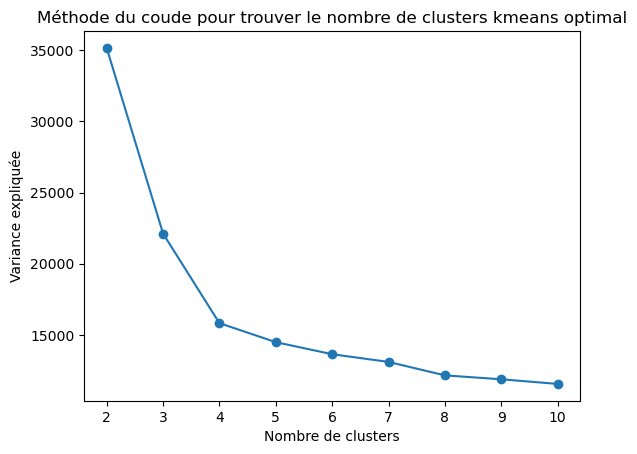

In [9]:
variances = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features)
    variances.append(kmeans.inertia_)

plt.plot(range(2, 11), variances, marker='o')
plt.title("Méthode du coude pour trouver le nombre de clusters kmeans optimal")
plt.xlabel("Nombre de clusters")
plt.ylabel("Variance expliquée")
plt.show()

In [11]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(features)
cluster_labels_kmeans = kmeans.labels_

/home/mano/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [12]:
agglomerative = AgglomerativeClustering(n_clusters=8)
agglomerative.fit(itemdescription_embeddings)
cluster_labels_agglomerative = agglomerative.labels_

La visualisation des clusters a été effectuée en utilisant la technique t-SNE pour réduire la dimensionnalité des données et les visualiser en deux dimensions. J'ai tracé les données avec des couleurs correspondant aux étiquettes de cluster obtenues par les deux méthodes de clustering.

In [13]:
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(itemdescription_embeddings)

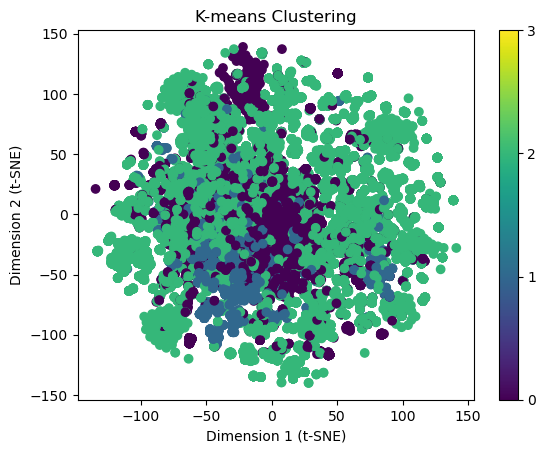

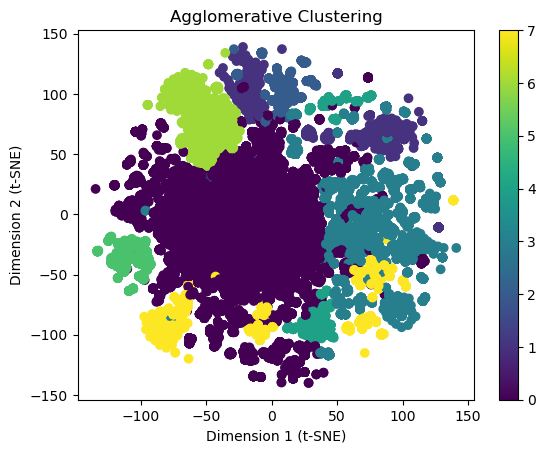

In [14]:
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=cluster_labels_kmeans, cmap='viridis')
plt.title('K-means Clustering')
plt.xlabel('Dimension 1 (t-SNE)')
plt.ylabel('Dimension 2 (t-SNE)')
plt.colorbar(ticks=range(7))
plt.show()

plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=cluster_labels_agglomerative, cmap='viridis')
plt.title('Agglomerative Clustering')
plt.xlabel('Dimension 1 (t-SNE)')
plt.ylabel('Dimension 2 (t-SNE)')
plt.colorbar(ticks=range(10))
plt.show()

La visualisation via t-SNE permet d'avoir un aperçu en 2D des clusters mais ne les représente pas fidèlement.

Dans le but d'évaluer la qualité de mon travail, j'ai calculé le score de silhouette pour évaluer la qualité des clusters obtenus par les deux méthodes. En utilisant l'analyse LDA (Latent Dirichlet Allocation) et l'analyse des sentiments, j'ai également généré les noms des clusters pour les inclure dans la dataframe.

In [15]:
silhouette_kmeans = silhouette_score(features, cluster_labels_kmeans)
silhouette_agglomerative = silhouette_score(itemdescription_embeddings, cluster_labels_agglomerative)

print("Silhouette Score - K-means:", silhouette_kmeans)
print("Silhouette Score - Agglomerative:", silhouette_agglomerative)

Silhouette Score - K-means: 0.3572854967701726
Silhouette Score - Agglomerative: 0.09246589


In [22]:
sample_df['kmeans_cluster'] = cluster_labels_kmeans

sample_df['agglomerative_cluster'] = cluster_labels_agglomerative

In [26]:
vectorizer = TfidfVectorizer(smooth_idf=True)
item_descriptions_tfidf = vectorizer.fit_transform(sample_df['itemdescription'])
n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(item_descriptions_tfidf)
feature_names = vectorizer.get_feature_names_out()
n_top_words = 1  # Number of top words to display

cluster_names_kmeans = []
for cluster_id in range(n_topics):
    cluster_items = sample_df[sample_df['kmeans_cluster'] == cluster_id]
    cluster_descriptions = ' '.join(cluster_items['itemdescription'])
    cluster_descriptions_tfidf = vectorizer.transform([cluster_descriptions])
    cluster_term_scores = cluster_descriptions_tfidf.toarray()[0]
    top_words_indices = cluster_term_scores.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_indices]
    cluster_name = ", ".join(top_words)
    cluster_names_kmeans.append(cluster_name)

In [23]:
vectorizer = TfidfVectorizer(smooth_idf=True)
item_descriptions_tfidf = vectorizer.fit_transform(sample_df['itemdescription'])
n_topics = 8
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(item_descriptions_tfidf)
feature_names = vectorizer.get_feature_names_out()
n_top_words = 1

cluster_names_agglomerative = []
for cluster_id in range(n_topics):
    cluster_items = sample_df[sample_df['agglomerative_cluster'] == cluster_id]
    cluster_descriptions = ' '.join(cluster_items['itemdescription'])
    cluster_descriptions_tfidf = vectorizer.transform([cluster_descriptions])
    cluster_term_scores = cluster_descriptions_tfidf.toarray()[0]
    top_words_indices = cluster_term_scores.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_indices]
    cluster_name = ", ".join(top_words)
    cluster_names_agglomerative.append(cluster_name)

In [52]:
sample_df['kmeans_cluster'] = cluster_labels_kmeans
cluster_names_dict_kmeans = {label: name for label, name in zip(range(n_topics), cluster_names_kmeans)}
sample_df['kmeans_cluster_name'] = sample_df['kmeans_cluster'].map(cluster_names_dict_kmeans)

sample_df['agglomerative_cluster'] = cluster_labels_agglomerative
cluster_names_dict = {label: name for label, name in zip(range(len(cluster_names_agglomerative)), cluster_names_agglomerative)}
sample_df['agglomerative_cluster_name'] = sample_df['agglomerative_cluster'].map(cluster_names_dict)


J'ai ensuite affiché quelques éléments de chaque cluster pour en déceler la pertinence.

In [45]:
for cluster_id in range(4):
    cluster_name = cluster_names_kmeans[cluster_id]
    print("Kmeans Cluster", cluster_id, "(", cluster_name, ")")
    cluster_items = sample_df[sample_df['kmeans_cluster'] == cluster_id]
    print(cluster_items[['itemName', 'description']].head(5))
    print()

Kmeans Cluster 0 ( de )
                              itemName                    description
4015559                         salade                         salade
1905527                poisson bar svp              message generique
2090351              poivron rouge  kg               poivron rouge kg
325674             minis viennoiseries            minis viennoiseries
4894842  colons sauce américaine 500ml  colons sauce américaine 500ml

Kmeans Cluster 1 ( cl )
                          itemName                                description
1339918             st joseph 75cl                      aop "domaine richard"
6292845            coupe champagne                            coupe champagne
2268622  tab grue noisettes - lait  tablette grue de cacao / noisettes - lait
6971933                     gin ld                             gin long drink
6883466         pierre d'alun 60gr                         pierre d'alun 60gr

Kmeans Cluster 2 ( product )
                     itemName des

On observe que les clusters agglomératifs sont plus pertinents pour catégoriser les éléments de la dataframe : les commentaires sont séparés des boissons, des menus, des suppléments etc..

In [46]:
for cluster_id in range(8):
    cluster_name = cluster_names_agglomerative[cluster_id]
    print("Agglomerative Cluster", cluster_id, "(", cluster_name, ")")
    cluster_items = sample_df[sample_df['agglomerative_cluster'] == cluster_id]
    print(cluster_items[['itemName', 'description']].head(10))
    print()

Agglomerative Cluster 0 ( de )
                                    itemName  \
4015559                               salade   
3417095                           granité gm   
2090351                    poivron rouge  kg   
3211493                              tartine   
5391769  prts thon /avocat /coriandre/menthe   
1339918                       st joseph 75cl   
1750070                              calzone   
325674                   minis viennoiseries   
6578458                      crepe balthazar   
5991997                       schweppes 33cl   

                               description  
4015559                             salade  
3417095                         granité gm  
2090351                   poivron rouge kg  
3211493                            tartine  
5391769  prts thon/avocat/coriandre/menthe  
1339918              aop "domaine richard"  
1750070                            calzone  
325674                 minis viennoiseries  
6578458                            

J'ai créé une fonction associate_with_cluster qui prend en entrée un élément de la forme de xeud dans ma dataframe, lui associe un cluster et l'ajoute à la dataframe réduite.

In [40]:
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    text = text.lower()
    return text

In [41]:
def associate_item_with_cluster(item, sample_df, model, kmeans, agglomerative):
    description = preprocess_text(item['description'])
    item_embedding = model.encode([description], convert_to_tensor=True)
    embeddings = np.concatenate((itemdescription_embeddings, item_embedding), axis=0)
    cluster_labels_kmeans = kmeans.fit_predict(features)
    cluster_labels_agglomerative = agglomerative.fit_predict(embeddings)
    kmeans_cluster_label = cluster_labels_kmeans[-1]
    agglomerative_cluster_label = cluster_labels_agglomerative[-1]
    item['kmeans_cluster'] = kmeans_cluster_label
    item['agglomerative_cluster'] = agglomerative_cluster_label
    kmeans_cluster_name = cluster_names_kmeans[kmeans_cluster_label]
    agglomerative_cluster_name = cluster_names_agglomerative[agglomerative_cluster_label]
    item['kmeans_cluster_name'] = kmeans_cluster_name
    item['agglomerative_cluster_name'] = agglomerative_cluster_name
    sample_df = sample_df.append(item)
    print("Item:")
    print(item)
    print("K-means Cluster:", kmeans_cluster_label, "Name:", kmeans_cluster_name)
    print("Agglomerative Cluster:", agglomerative_cluster_label, "Name:", agglomerative_cluster_name)
    return sample_df

Cette fonction retourne un élément aléatoire de la dataframe originale, n'ayant pas été choisi dans la dataframe réduite :

In [42]:
def generate_random_item(df):
    excluded_indices = sample_df.index
    eligible_indices = df.index[~df.index.isin(excluded_indices)]
    random_index = random.choice(eligible_indices)
    random_item = df.loc[random_index]
    print("Random Item Details:")
    print("ID: ", random_item['id'])
    print("Name: ", random_item['itemName'])
    print("Description: ", random_item['description'])
    print("Amount: ", random_item['amount'])
    print("Tax Rate: ", random_item['taxRate'])
    print()
    return random_item

In [66]:
new_item = generate_random_item(df)

Random Item Details:
ID:  30553e05-79e8-40f0-a402-d2b86c2643ff
Name:  menu saveurs 3 plats
Description:  menu(s) saveurs 3 plats
Amount:  43.0
Tax Rate:  1000.0



Afin de tester le bon fonctionnement de la fonction, j'ai appliqué associate_item_with_cluster à un élément choisi par generate_random_item

In [67]:
associate_item_with_cluster(new_item, sample_df, model, kmeans, agglomerative)

/home/mano/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Item:
id                                  30553e05-79e8-40f0-a402-d2b86c2643ff
amount                                                              43.0
description                                      menu(s) saveurs 3 plats
date                                                                 NaN
itemName                                            menu saveurs 3 plats
quantity                                                             NaN
taxAmount                                                           3.91
type                                                                 NaN
taxRate                                                           1000.0
itemdescription               menu saveurs  plats menu(s) saveurs  plats
amount_scaled                                                   0.339947
taxRate_scaled                                                  0.101143
kmeans_cluster                                                         0
agglomerative_cluster                        

/tmp/ipykernel_156418/3802833480.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item['kmeans_cluster'] = kmeans_cluster_label
/tmp/ipykernel_156418/3802833480.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item['kmeans_cluster'] = kmeans_cluster_label
/tmp/ipykernel_156418/3802833480.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item['agglomerative_cluster'] = agglomerative_cluster_label
/tmp/ipykernel_156418/380283348

,id,amount,description,date,itemName,quantity,taxAmount,type,taxRate,itemdescription,amount_scaled,taxRate_scaled,kmeans_cluster,agglomerative_cluster,kmeans_cluster_name,agglomerative_cluster_name
4015559,1c35ce08-c11c-40ad-9a2f-3c5a944bd04b,1.86,salade,NaN,salade,NaN,0.1,NaN,550.0,salade salade,-0.077746,-0.938073,0,0,de,de
1905527,92234033-3b66-4368-92e1-a43299692b89,0.0,message generique,NaN,poisson bar svp,NaN,0.0,NaN,100.0,poisson bar svp message generique,-0.096630,-1.977289,0,6,de,generique
3417095,2d5d1e5c-3734-47be-88c9-a8db14dc3cf6,4.5,granité gm,NaN,granité gm,NaN,0.41,NaN,1000.0,granité gm granité gm,-0.050942,0.101143,2,0,product,de
6260124,9d5f96b5-d0b8-41b6-abd4-c4e7e8d4b0c9,6.5,product,NaN,Exotic Olada,NaN,0.591,NaN,1000.0,Exotic Olada product,-0.030636,0.101143,2,3,product,product
2090351,1bef095b-fef7-48ef-9038-eef924bd7752,4.45,poivron rouge kg,NaN,poivron rouge kg,NaN,0.06,NaN,550.0,poivron rouge kg poivron rouge kg,-0.051450,-0.938073,0,0,de,de
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3487449,1bc0befa-c50a-4de9-87ea-bead04623562,4.0,beignets triangulaires aux légumes,NaN,vegetable samoussa,NaN,0.09,NaN,210.0,vegetable samoussa beignets triangulaires aux ...,-0.056018,-1.723259,0,0,de,de
5492805,272d616e-6bd5-4dfd-b8b1-e8a54fd1b9da,3.0,product,NaN,Coca-Cola 50cl,NaN,0.156,NaN,550.0,Coca-Cola cl product,-0.066171,-0.938073,0,7,de,coca
6897829,dd5d8d02-a965-4929-9d2c-103426901032,3.8,quiche,NaN,quiche,NaN,0.08,NaN,210.0,quiche quiche,-0.058049,-1.723259,0,0,de,de
4345399,74418c8a-f3b0-4bd6-882a-a54f333cfee9,3.91,biscuits pepites chocolat 150 g les deux gour...,NaN,150g bisc pepites chocolat - l2g,NaN,0.41,NaN,550.0,g bisc pepites chocolat - lg biscuits pepites ...,-0.056932,-0.938073,0,0,de,de


In [55]:
np.save('cluster_labels_kmeans.npy', cluster_labels_kmeans)

np.save('cluster_names_kmeans.npy', cluster_names_kmeans)

np.save('vectorizer_vocabulary.npy', vectorizer.get_feature_names_out())

np.save('cluster_labels_agglomerative.npy', cluster_labels_agglomerative)

np.save('cluster_names_agglomerative.npy', cluster_names_agglomerative)